## Mini PJT

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

Data file이 많은 이유는 DB에 테이블 단위로 파일을 생성했기 때문!<br>

실제 현업 하는 방식과 비슷하다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 데이터 불러오기 

In [ ]:
# instacart 데이터를 모두 불러옵니다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

base_path = '/content/drive/MyDrive/이어드림스쿨/Today_I_learn/5월/Part4. 머신러닝/data/instacart-market-basket-analysis/'
aisles = pd.read_csv(base_path + 'aisles.csv')
departments = pd.read_csv(base_path + 'departments.csv')
prior = pd.read_csv(base_path + 'order_products__prior.csv')
train = pd.read_csv(base_path + 'order_products__train.csv')
orders = pd.read_csv(base_path + 'orders.csv')
products = pd.read_csv(base_path + 'products.csv')


In [ ]:
print(aisles.shape, departments.shape, prior.shape, train.shape, orders.shape, products.shape)

(134, 2) (21, 2) (32434489, 4) (1384617, 4) (3421083, 7) (49688, 4)


In [ ]:
# data가 너무 많아서 10,000개만 sampling 하여 사용하자.
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [ ]:
# 구매내역을 통해 고객을 정의하여 clustering 해보자. (row 단위는 유저 단위)

In [ ]:
# 불러온 모든 테이블을 합칩니다.
temp = pd.merge(orders, prior_sample, on ='order_id') # inner join
temp = pd.merge(temp, products, on ='product_id')
temp = pd.merge(temp, aisles, on ='aisle_id')
temp = pd.merge(temp, departments, on ='department_id')
temp
# train data는 prior data와 같아서 merge 안함

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [ ]:
# primary key(PK) = order_id + user_id + product_id

In [ ]:
# 1만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
temp.user_id.value_counts() # 972명의 고객

# 각 물품을 몇개 샀는지는 안나옴, 1개씩 구매한 거로 나옴
temp.product_name.value_counts() 

temp.aisle.value_counts() # 133개, 거의 모든 카테고리-중분류가 다 나옴

temp.department.value_counts() # 21개, 카테고리-대분류 다 나옴 

temp.order_dow.value_counts() # 어느 요일에 구매했는지

temp.order_hour_of_day.value_counts() # 어느 시간에 구매했는지(온라인 쇼핑몰임)

Banana                               156
Bag of Organic Bananas               119
Organic Strawberries                  73
Organic Baby Spinach                  70
Organic Hass Avocado                  68
                                    ... 
Organic Bunch Arugula                  1
Russet Potatoes                        1
Organic Whole Crimini Mushrooms        1
Yukon Gold Potatoes                    1
Organic Short Brown Sprouted Rice      1
Name: product_name, Length: 4511, dtype: int64

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [ ]:
# transaction->user-level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department(21개)-기준        2. aisle        3. Product_name

X = pd.crosstab(index = temp.user_id, columns = temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [ ]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법) -> clustering은 해석이 중요하니까!
from sklearn.manifold import TSNE # 변환함수라 scaler와 동일하게 사용하면 됨

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[ 11.262295  ,  20.07638   ],
       [ 26.525806  ,   9.346538  ],
       [  0.88421935,  23.332245  ],
       ...,
       [ 14.792153  ,   7.740676  ],
       [ 16.343231  ,  23.959122  ],
       [ 15.702102  , -12.749154  ]], dtype=float32)

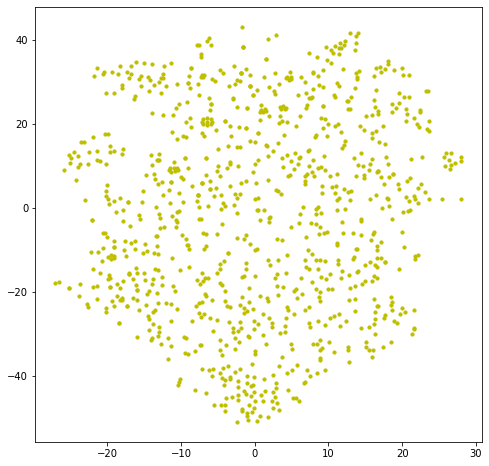

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [ ]:
# K-means를 돌려봅시다.

from sklearn.cluster import KMeans # 1. K-means
from sklearn.cluster import AgglomerativeClustering # 2. Hierarchical Agglomerative Clustering
from sklearn.cluster import DBSCAN # 3. DBSCAN
from sklearn.cluster import SpectralClustering # 4. Spectral Clustering

from sklearn.metrics import silhouette_score

model = KMeans(n_clusters = 4)
model2 = KMeans(n_clusters = 2)
# unsupervised setting -> y 없음
pred = model.fit_predict(X) 
pred2 = model2.fit_predict(X) 

# Clustering은 fit, predict가 따로 있을 필요 없음 - unsupervised learning
print('silhouette_score : % .4f' % silhouette_score(X,pred)) # silhouette_score = [-1, 1] / -1 : worst, 1 : best
print('silhouette_score : % .4f' % silhouette_score(X,pred2))

silhouette_score :  0.1929
silhouette_score :  0.3641


In [ ]:
# elbow method
sse = []
silhouettes = []

for K in range(2,11) : # K -cluster 개수
    model = KMeans(n_clusters=K) # K : 2 - 10
    pred = model.fit_predict(X)
    sse.append(model.inertia_) # SSE
    silhouettes.append(silhouette_score(X,pred))

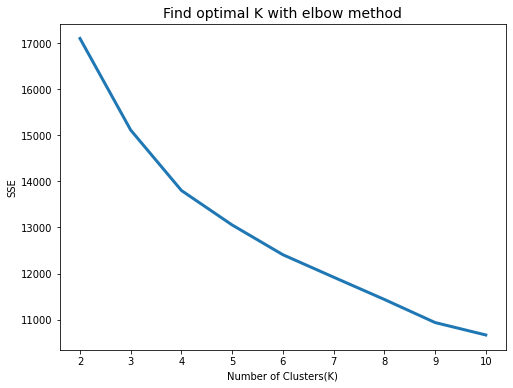

In [ ]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 11), sse, lw=3) # lw = line width
plt.show()

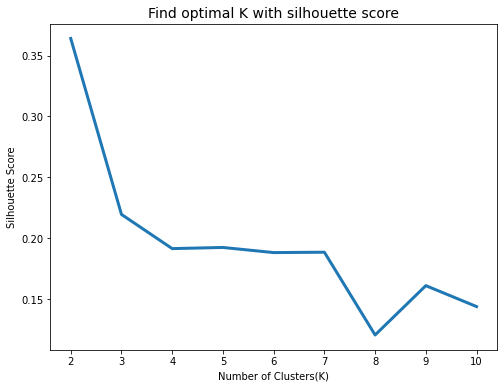

In [ ]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouettes, lw=3)
plt.show()

In [ ]:
model = KMeans(n_clusters = 4)
model2 = KMeans(n_clusters = 2)

pred = model.fit_predict(X) 
pred2 = model2.fit_predict(X) 

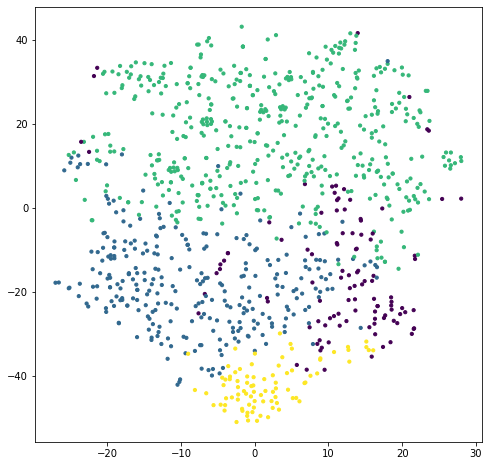

In [ ]:
# cluster 4개
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c = pred, cmap="viridis") # c = predict 결과에 색깔별로 칠해준다
plt.show()

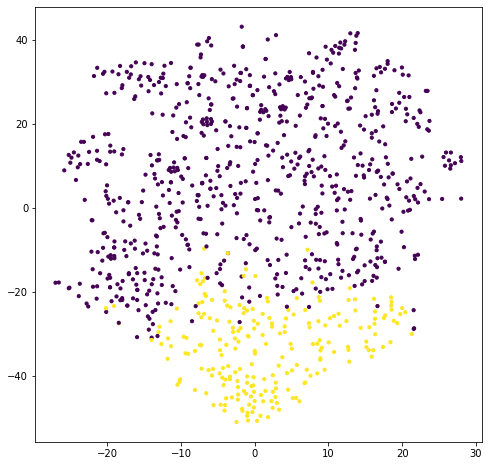

In [ ]:
# cluster 2개
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c = pred2, cmap="viridis") 
plt.show()

In [ ]:
# see summary
X['cluster_label'] = pred2 # cluster 2개
X['Cluster_label'] = pred # cluster 4개
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
503,0,0,0,0,1,0,2,1,0,0,...,1,0,0,1,0,0,2,0,0,2
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,2
1059,0,0,3,0,3,0,0,8,0,0,...,2,0,0,2,0,0,8,2,1,0
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,4,1,0,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,2


In [ ]:
group1 = X.loc[X.cluster_label == 0, :]
group2 = X.loc[X.cluster_label == 1, :]
print(group1.shape, group2.shape)

(750, 22) (222, 22)


In [ ]:
group1.mean() # top3 : product, dairy eggs, beverages

department
alcohol            0.033333
babies             0.105333
bakery             0.297333
beverages          0.776000
breakfast          0.201333
bulk               0.002667
canned goods       0.282667
dairy eggs         1.273333
deli               0.241333
dry goods pasta    0.202667
frozen             0.653333
household          0.252000
international      0.073333
meat seafood       0.166667
missing            0.014667
other              0.016000
pantry             0.512000
personal care      0.129333
pets               0.026667
produce            1.668000
snacks             0.728000
cluster_label      0.000000
dtype: float64

In [ ]:
group2.mean() # top3 : product, dairy eggs, snacks

department
alcohol            0.009009
babies             0.234234
bakery             0.590090
beverages          0.986486
breakfast          0.391892
bulk               0.018018
canned goods       0.675676
dairy eggs         3.117117
deli               0.621622
dry goods pasta    0.463964
frozen             1.153153
household          0.270270
international      0.139640
meat seafood       0.450450
missing            0.018018
other              0.004505
pantry             0.963964
personal care      0.126126
pets               0.036036
produce            7.486486
snacks             1.423423
cluster_label      1.000000
dtype: float64

In [ ]:
group3 = X.loc[X.Cluster_label == 0, :]
group4 = X.loc[X.Cluster_label == 1, :]
group5 = X.loc[X.Cluster_label == 2, :]
group6 = X.loc[X.Cluster_label == 3, :]


print(group3.shape, group4.shape, group5.shape, group6.shape)

(107, 23) (288, 23) (493, 23) (84, 23)


In [ ]:
group3.mean()

department
alcohol            0.009346
babies             0.308411
bakery             0.850467
beverages          1.271028
breakfast          0.616822
bulk               0.000000
canned goods       0.514019
dairy eggs         4.822430
deli               0.485981
dry goods pasta    0.598131
frozen             1.887850
household          0.327103
international      0.177570
meat seafood       0.476636
missing            0.056075
other              0.009346
pantry             1.299065
personal care      0.308411
pets               0.065421
produce            3.383178
snacks             2.485981
cluster_label      0.467290
Cluster_label      0.000000
dtype: float64

In [ ]:
group4.mean()

department
alcohol            0.017361
babies             0.118056
bakery             0.350694
beverages          0.600694
breakfast          0.201389
bulk               0.006944
canned goods       0.461806
dairy eggs         1.322917
deli               0.333333
dry goods pasta    0.232639
frozen             0.545139
household          0.197917
international      0.093750
meat seafood       0.284722
missing            0.017361
other              0.010417
pantry             0.569444
personal care      0.083333
pets               0.013889
produce            4.361111
snacks             0.604167
cluster_label      0.305556
Cluster_label      1.000000
dtype: float64

In [ ]:
group5.mean()

department
alcohol            0.040568
babies             0.085193
bakery             0.233266
beverages          0.770791
breakfast          0.176471
bulk               0.002028
canned goods       0.225152
dairy eggs         1.002028
deli               0.200811
dry goods pasta    0.176471
frozen             0.569980
household          0.259635
international      0.056795
meat seafood       0.129817
missing            0.006085
other              0.018256
pantry             0.432049
personal care      0.119675
pets               0.022312
produce            0.831643
snacks             0.626775
cluster_label      0.000000
Cluster_label      2.000000
dtype: float64

In [ ]:
group6.mean()

department
alcohol             0.011905
babies              0.261905
bakery              0.559524
beverages           1.333333
breakfast           0.321429
bulk                0.035714
canned goods        0.750000
dairy eggs          3.047619
deli                0.857143
dry goods pasta     0.440476
frozen              1.261905
household           0.345238
international       0.142857
meat seafood        0.333333
missing             0.011905
other               0.000000
pantry              0.976190
personal care       0.107143
pets                0.071429
produce            10.535714
snacks              1.345238
cluster_label       1.000000
Cluster_label       3.000000
dtype: float64

#### 정량평가만이 정답이 아니라 clustering은 도메인 정보와 함께 해석을 하는 것이 중요하다.